## Import Libraries

All libraries required for Exploratory Data Analysis are imported.  

In [220]:
## Pickle allows Python objects to be saved for later use, and retrieved
import pickle

## Pandas required to manipulate data into user-friendly data structure
import pandas as pd

## Numpy is used to execute various mathematical functions
import numpy as np

## Matplotlib and Seaborn are both plotting tools used to support datavisualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## An sklearn function used to convert a collection of text documents into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

## Import plotly, an alternative datavisualisation tool
import plotly.express as px

## Load Dataframe

The data that will be explored during this section has been stored, using pickle, in a dataframe called 'cleaned_labelled_tweets'.  This dataframe was compiled from data extracted from the Twitter API (see **Step 1 - Obtain Data**), manually labelled and then cleaned (see **Step 2 - Scrub Data**).  

Pickle can therefore be used to load the stored dataframe.

In [6]:
## Import saved dataframe using pickle
df = pd.read_pickle('cleaned_labelled_tweets')

In [7]:
## Reset the index (and drop the previous index)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

Once loaded, the dataframe can be previewed using **df.head()**.

In [8]:
## Display the first five records
df.head()

,network,datetime,original_tweet,subject,sentiment,lemmatized_tweets_tokens,lemmatized_tweets_string
0,@VodafoneUK,2019-12-04 08:05:14,@VodafoneUK Plus £2.28 package &amp; posting !...,device,0.000000,"[plus, 2.28, package, posting]",plus 2.28 package posting
1,@VodafoneUK,2019-12-04 08:04:05,I have repeatedly asked how to get a refund so...,customer service,-0.300000,"[repeatedly, asked, get, refund, use, another,...",repeatedly asked get refund use another provid...
2,@VodafoneUK,2019-12-04 08:01:19,"I have supplied visa details twice, I have bee...",customer service,-0.300000,"[supplied, visa, detail, twice, subjected, hor...",supplied visa detail twice subjected horrendou...
3,@VodafoneUK,2019-12-04 07:57:42,@VodafoneIN promised yesterday I’d receive no ...,customer service,-0.250000,"[promised, yesterday, id, receive, call, would...",promised yesterday id receive call would get e...
4,@VodafoneUK,2019-12-04 07:57:16,@VodafoneUK you send texts about rewards - thi...,promotion,-0.155556,"[send, text, reward, morning, lindt, take, app...",send text reward morning lindt take app never ...


As can be seen from the above, tweets are stored in various forms (original, lemmatized as tokens and lemmatized as strings).  They are categorised by network (e.g. Vodafone, EE etc.) and subject.  Each tweet has also been given a sentiment rating.  

## Distribution of Tweets by Network

As a starting point, it makes sense to review the number of tweets by network.  Ideally these will be reasonably equally distributed across networks.

In [131]:
## Use the groupby function to calculate the number of reviews by network
network = df.groupby(['network'], as_index=False).count()

## Use plotly to generate a bar chart
fig = px.bar(network, x='network', y='subject')

## Add a title to the plot
fig.update_layout(title={'text':'Number of Tweets by Network', 
                         'x':0.5,'xanchor':'center'}, xaxis_title="Mobile Network", yaxis_title='Number of Tweets')

## Distribution of Sentiment by Network

Each tweet has been assigned a sentiment rating by TextBlob (see **Step 2 - Scrub Data**).  This sentiment rating ranges from -1 (very negative) to 0 (neutral) to +1 (very positive).  To understand whether there is any notable difference between the sentiment of people tweeting about each network, a box plot is constructed using Plotly.

In [149]:
## Create a boxplot using plotly.  Sentiment is on the x-axis with a plot being made for each network
fig = px.box(df, x='sentiment', color='network', hover_data=['network'])

## Change the orientation of the plot to horizontal
fig.update_traces(orientation='h') 

## Add a title to the plot
fig.update_layout(title={'text':'Distribution of Sentiment by Network', 
                         'x':0.45,'xanchor':'center'})

## Show the plot
fig.show()

The chart above shows that the median sentiment for all networks is 0.  However, it is important to note that the lower and upper fence for Vodafone is notably below any of the other networks.  This indicates a greater lack of satisfaction with Vodafone on Twitter.  In contrast, EE and O2 appear to perform better on this measure.

## Distribution of Tweet Subject by Network

Next, the distribution of tweets by subject is scrutinised.  For this task, a radial plot is chosen.  The plotly library is best suited to this task.

In [113]:
## Group data by the number of tweets per subject and network
subject_df = df.groupby(['subject','network'], as_index=False).count()

## Use plotly to create a raidal (polar) plot 
fig = px.line_polar(subject_df, theta='subject', r='datetime', color='network')

## Add a title to the plot
fig.update_layout(title={'text':'Number of Tweets by Subject & Network', 
                         'x':0.4,'xanchor':'center'})
fig.show()

The chart above illustrates the following:

- Vodafone appears to have the most tweets relating to customer service.  
- Network issues are most prevalent with O2 (followed by Three)
- The biggest number of tweets are classified as Other.  This may suggest that a finer degree of categorisation is required.

Given that the number of tweets available per network is not equal, it makes sense to also consider the proportion of tweets per subject (not just the absolute number). Again, this is done using Plotly.

In [222]:
## Create an empty dataframe
subject_df = pd.DataFrame(columns=['network','subject'])

## Run a for loop that iterates through each network
for network in ['@VodafoneUK','@EE','@O2','@ThreeUK']:
    
    ## Create a temporary dataframe to contain the proportion of tweets per subject by network
    temporary_df = pd.DataFrame(df.loc[df['network']==network]['subject'].value_counts(normalize=True))
    temporary_df['network'] = network
    
    ## Append the temporary dataframe to the main dataframe
    subject_df = pd.concat([subject_df, temporary_df], axis=0, sort=False)

## Reset the index and rename the columns to provide greater explainability
subject_df.reset_index(inplace=True)

subject_df.rename(columns={'index':'subject','network':'network',
                           'subject':'proportion of tweets'},inplace=True)


In [227]:
## Use plotly to create the polar plot
fig = px.scatter_polar(subject_df, theta='subject', r='proportion of tweets', color='network')

## Add a title to the plot
fig.update_layout(title={'text':'Proportion of Tweets by Subject & Network', 
                         'x':0.4,'xanchor':'center'})
fig.show()

For clarity, a scatter polar plot is used above.  What is clear is that Vodafone continues to have the biggest proportion of tweets relating to customer service.  Meanwhile O2 and Three have a similar proportion of tweets relating to network issues.

## Top 20 Words: Unigrams

Next, the most frequently used words will be reviewed, by network.  To do this, it is first necessary to build a function to isolate the top n most frequently used words for a given corpus.  This is done below.

In [210]:
## Define function to identify the top n most frequently used words for a given corpus
def get_top_n_words(corpus, n=None):
    
    ## Create a CountVectorizer to calculate how many times each word appears
    vec = CountVectorizer().fit(corpus)
    
    ## Transform the corpus using the CountVectorizer
    bag_of_words = vec.transform(corpus)
    
    ## Transform the bag_of_words into a vector, in which each value corresponds to a given word
    sum_words = bag_of_words.sum(axis=0) 
    
    ## Create a list of tuples of the form (word,  frequency)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    ## Sort the list of tuples by the frequency
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    ## Return the sorted list of tuples
    return words_freq[:n]

Having defined this function, it is now possible to plot the 20 most common words for each phone network.  This is done below using Seaborn/Matplotlib.

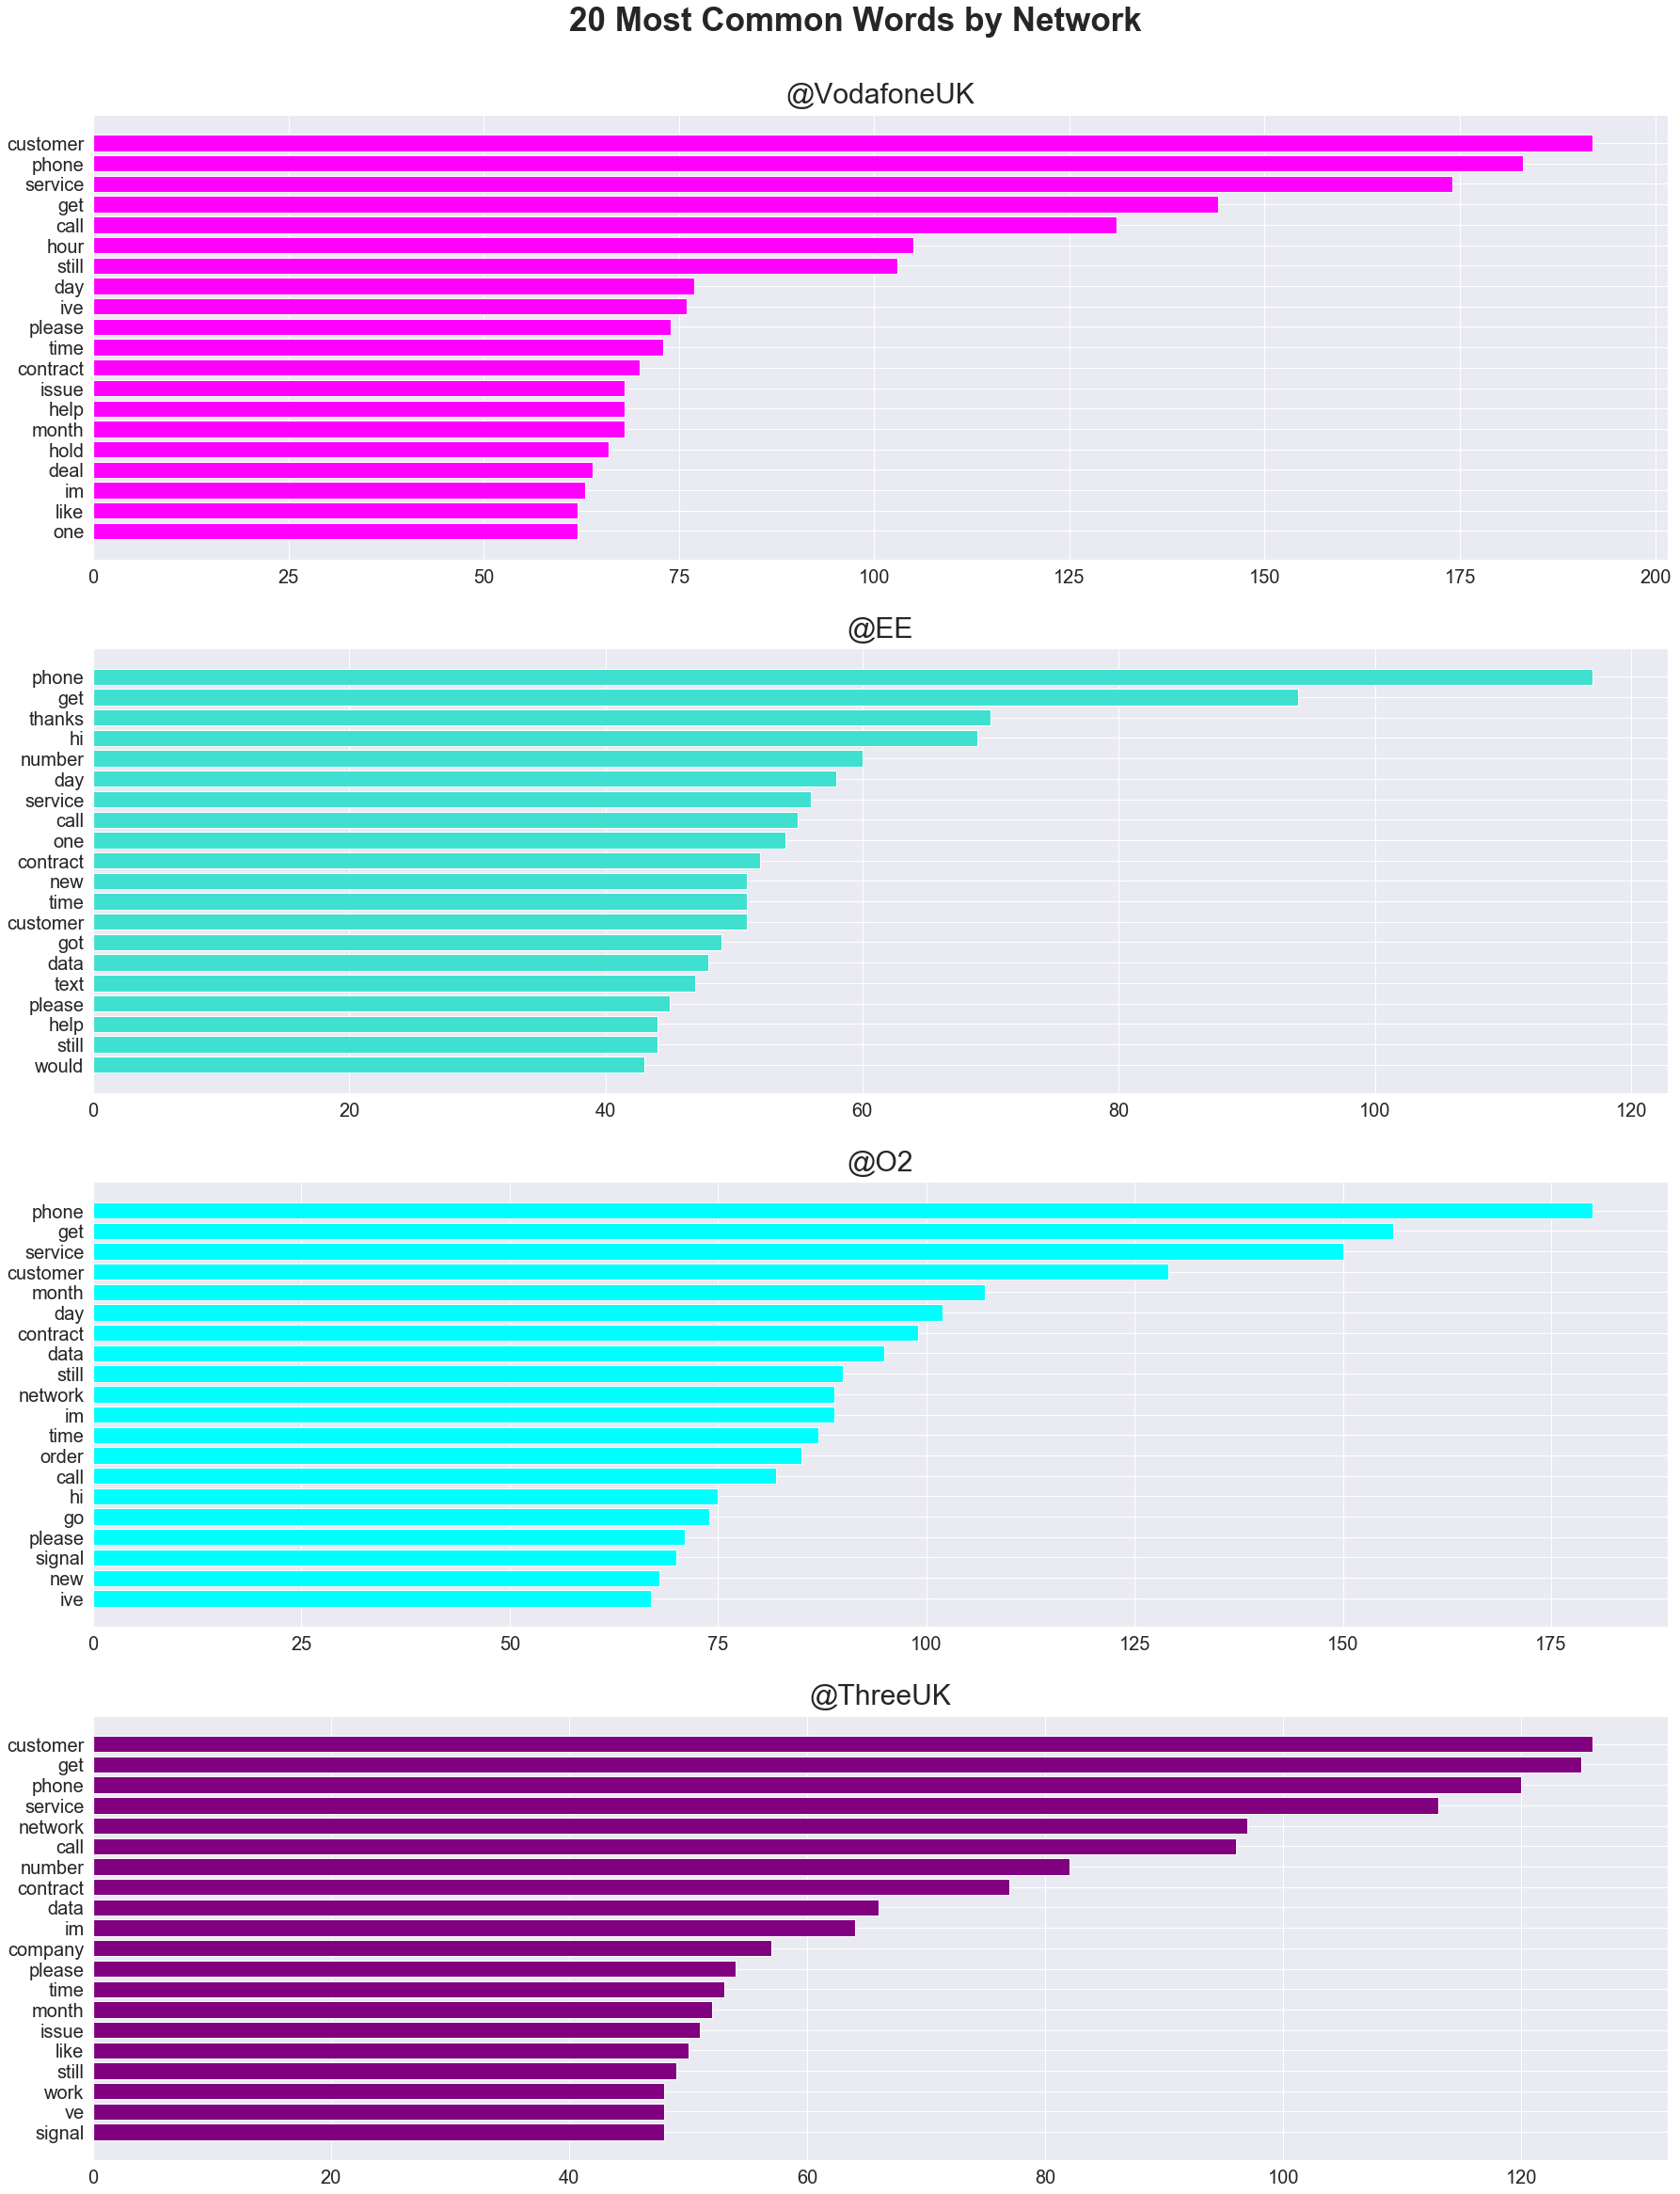

In [218]:
## Set the size of the x and y axis labels
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

## Define the colour for each plot
colours = ['magenta','turquoise','cyan','purple']

## Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,40))

## Give the figure a title
fig.suptitle('20 Most Common Words by Network', fontsize=35, y=0.92, fontweight='bold')

## Using a for loop, iterate through each network
for key, val in enumerate(['@VodafoneUK','@EE','@O2','@ThreeUK']):
    
    ## Identify the top 20 words for a given network using the get_top_n_words function
    top_words = get_top_n_words(df['lemmatized_tweets_string'].loc[df['network']==val], n=20)
    
    ## Transform the results into a Dataframe, sorted by frequency
    top_words_df = pd.DataFrame(top_words, columns=['Word','Frequency'])
    top_words_df.sort_values(by=['Frequency'], inplace=True)
    
    ## Create the subplot (a horizontal bar chart)
    axes[key].barh(top_words_df['Word'], top_words_df['Frequency'], color=colours[key])
    
    ## Set subplot title
    axes[key].set_title(val, fontsize=30, fontdict={'verticalalignment':'bottom'})

## Show the plot, using the seaborn style 'darkgrid'
sns.set_style("darkgrid")
plt.show()

What is notable from the above is that the words 'customer' and 'service' appear in the top 20 words for every network.  This is a good indication that people often tweet about this topic.

It should also be noted that the word 'signal' and 'network' appears in the top 20 words for Three and O2, but not for Vodafone or EE.  It is likely that this is frequently encountered issue for customers of these networks.

## Top 20 Words: Bigrams

This activity is then repeated for the top 20 most commomnly used pairs of words.  Again, a function is defined to help with this task.

In [215]:
## Define function to identify the top n most frequently used pairs of words for a given corpus
def get_top_n_bigram(corpus, n=None):
    
    ## Create a CountVectorizer to calculate how many times each pair of words appears
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    
    ## Transform the corpus using the CountVectorizer
    bag_of_words = vec.transform(corpus)
    
    ## Transform the bag_of_words into a vector, in which each value corresponds to a given word
    sum_words = bag_of_words.sum(axis=0) 
    
    ## Create a list of tuples of the form (pair of words,  frequency)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    ## Sort the list of tuples by the frequency
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    ## Return the sorted list of tuples
    return words_freq[:n]

Having defined this function, it is now possible to plot the 20 most pairs of words (bigrams) for each phone network.  This is done below using Seaborn/Matplotlib.

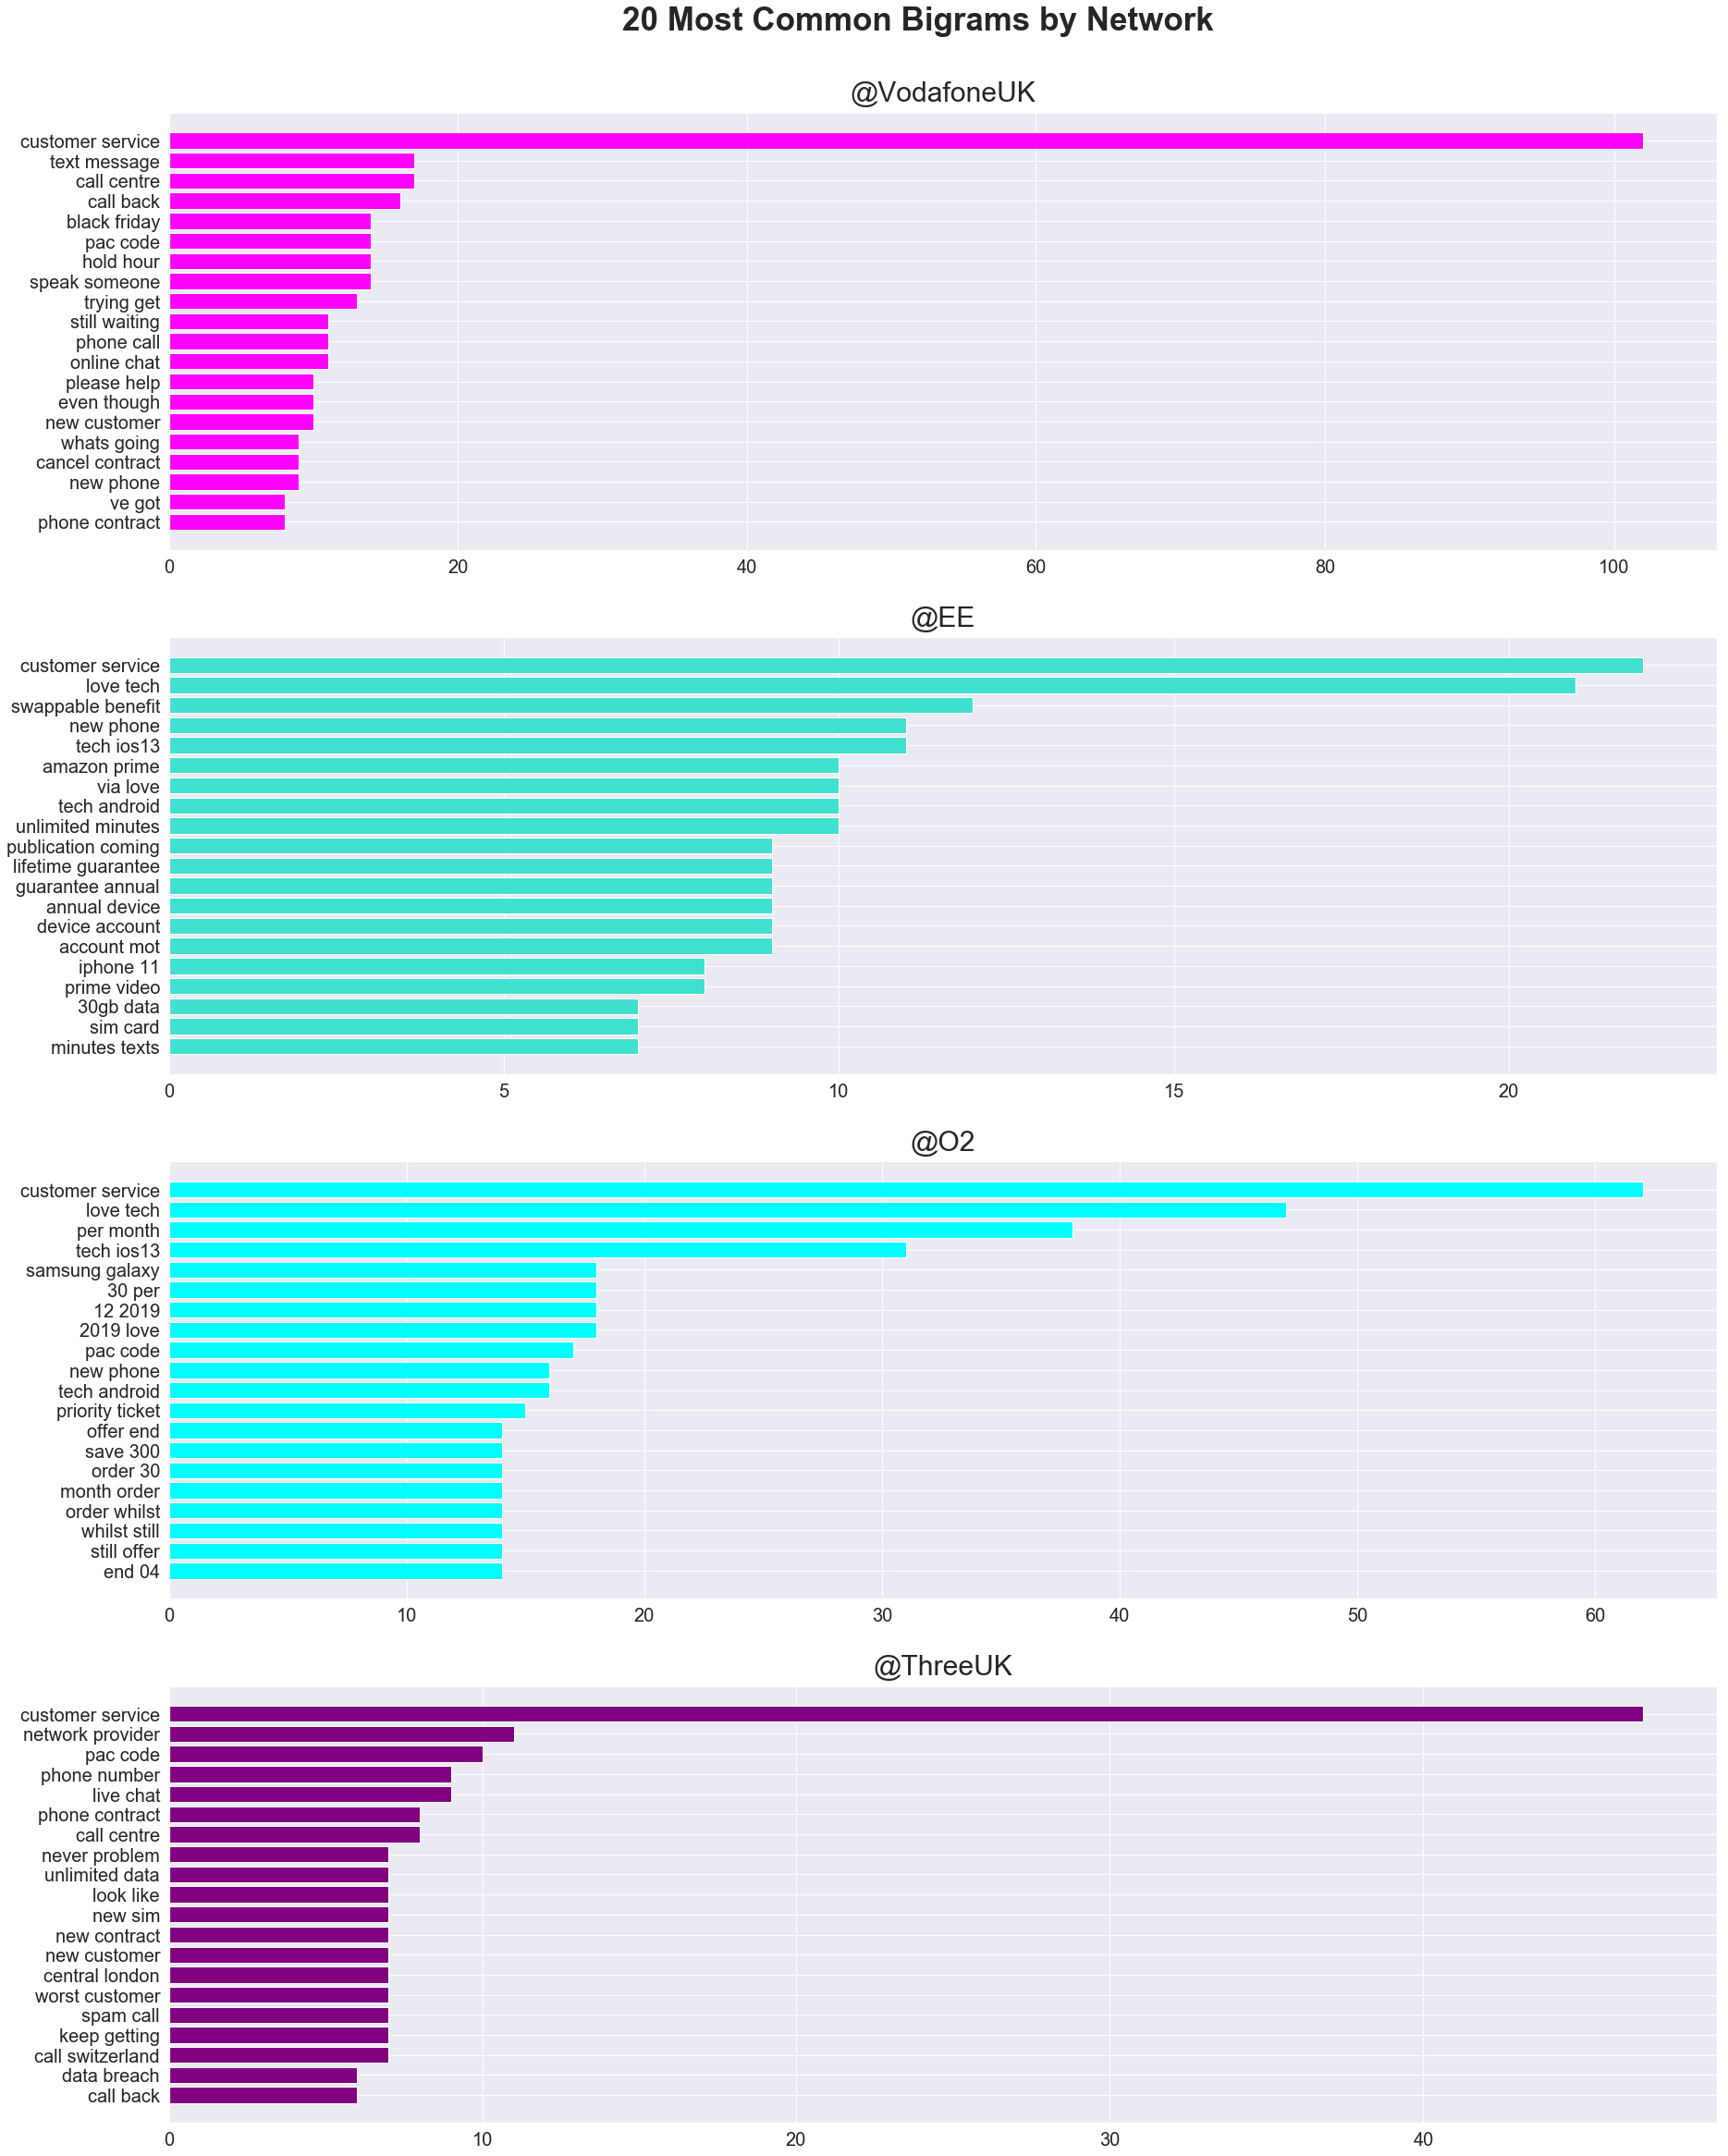

In [228]:
## Set the size of the x and y axis labels
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

## Define the colour for each plot
colours = ['magenta','turquoise','cyan','purple']

## Create a figure with 4 subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,40))

## Give the figure a title
fig.suptitle('20 Most Common Bigrams by Network', fontsize=35, y=0.92, fontweight='bold')

## Using a for loop, iterate through each network
for key, val in enumerate(['@VodafoneUK','@EE','@O2','@ThreeUK']):
    
    ## Identify the top 20 word pairs for a given network using the get_top_n_bigram function
    top_words = get_top_n_bigram(df['lemmatized_tweets_string'].loc[df['network']==val], n=20)
    
    ## Transform the results into a Dataframe, sorted by frequency
    top_words_df = pd.DataFrame(top_words, columns=['Word','Frequency'])
    top_words_df.sort_values(by=['Frequency'], inplace=True)
    
    ## Create the subplot (a horizontal bar chart)
    axes[key].barh(top_words_df['Word'], top_words_df['Frequency'], color=colours[key])
    
    ## Set subplot title
    axes[key].set_title(val, fontsize=30, fontdict={'verticalalignment':'bottom'})

## Show the plot, using the seaborn style 'darkgrid'
sns.set_style("darkgrid")
plt.show()

For every network, the phrase 'customer service' tops the list of most frequently used bigrams.  However, the frequency with which this phrase is used is highest for Vodafone.   Many of the other bigrams in the Vodafone chart also hint at poor customer service.  These include 'hold hour', 'still waiting' and 'trying get'.  All suggest that Vodafone are perhaps unresponsive. It seems to be a similar story for Three.  

In contrast, the bigrams for EE and O2 suggest that many questions relate to network promotions/benefits (e.g. 'amazon prime', 'swappable benefit' and 'priority ticket'.  